# Librerias

In [1]:
import tensorflow as tf
import pandas as pd
import unicodedata
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA


In [2]:
nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Pre-procesamiento de datos

In [54]:
#Creamos una variable df con el dataset
df = pd.read_csv("haha_2021_train.csv")

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               24000 non-null  object 
 1   text             24000 non-null  object 
 2   is_humor         24000 non-null  int64  
 3   votes_no         24000 non-null  int64  
 4   votes_1          24000 non-null  int64  
 5   votes_2          24000 non-null  int64  
 6   votes_3          24000 non-null  int64  
 7   votes_4          24000 non-null  int64  
 8   votes_5          24000 non-null  int64  
 9   humor_rating     9253 non-null   float64
 10  humor_mechanism  4800 non-null   object 
 11  humor_target     1629 non-null   object 
dtypes: float64(1), int64(7), object(4)
memory usage: 2.2+ MB


In [57]:
df.shape

(24000, 12)

In [4]:
df.drop(["votes_no","votes_1", "votes_2", "votes_3", "votes_4", "votes_5","humor_mechanism"],
          axis=1,
          inplace=True)

In [5]:
df=df[['text','is_humor']]
df.head()

,text,is_humor
0,Niveles de retraso mental: \n\n— Bajo.\n— Medi...,1
1,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1
2,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1
3,No se porqué me hago la cabeza deooos,0
4,Quisiera saber que hago durante la siesta de l...,0


In [6]:
df.text.isnull().any() # no missing values in is_sarcastic column

False

In [7]:
df.is_humor.isnull().any() # no missing values in headline column

False

In [8]:
df['text'] = df.text.apply(lambda x:x.lower())  # convert all words in text into lower case 
df['text'] = df.text.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))  # remove all punctuation 

In [9]:
df = df.assign(CleanText="", TokenizeText="", NoStopwords="", LemmaText="")

In [10]:
df['CleanText'] = df['text'].str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [11]:
df.head()

,text,is_humor,CleanText,TokenizeText,NoStopwords,LemmaText
0,niveles de retraso mental — bajo — medio — alt...,1,niveles de retraso mental bajo medio alto elev...,,,
1,—vamos luke desenfunda tu sable demuestra tu o...,1,vamos luke desenfunda tu sable demuestra tu od...,,,
2,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,te ofrezco algo agua café mi corazón mi vida e...,,,
3,no se porqué me hago la cabeza deooos,0,no se porqué me hago la cabeza deooos,,,
4,quisiera saber que hago durante la siesta de l...,0,quisiera saber que hago durante la siesta de l...,,,


In [12]:
def Tokenizacion(tweet):
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)
  return tweet_tokens

In [13]:
for i in range(len(df)):
  df['TokenizeText'][i] = Tokenizacion(df['CleanText'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
#Concatenar las stopwords aplicándose a una cuenta que genera contenido en inglés y español
stop_words = stop_words_sp | stop_words_en

In [15]:
df['NoStopwords'] = df['TokenizeText'].apply(lambda x: [item for item in x if item not in stop_words])

In [16]:
def Stemming(tweet):
  stemmer = SnowballStemmer("spanish")
  tweets_clean = []
  for word in tweet:
      stem_word = stemmer.stem(word)  # stemming word
      tweets_clean.append(stem_word)

  return tweets_clean

In [17]:
for i in range(len(df)):
  df["LemmaText"][i] = Stemming(df['NoStopwords'][i])
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
# df = df.assign(Corpus='')

In [19]:
# for i in range(len(df)):
#   df["Corpus"][i] = ' '.join(df['NoStopwords'][i])
  

In [20]:
df.head()

,text,is_humor,CleanText,TokenizeText,NoStopwords,LemmaText
0,niveles de retraso mental — bajo — medio — alt...,1,niveles de retraso mental bajo medio alto elev...,"[niveles, de, retraso, mental, bajo, medio, al...","[niveles, retraso, mental, bajo, medio, alto, ...","[nivel, retras, mental, baj, medi, alto, elev,..."
1,—vamos luke desenfunda tu sable demuestra tu o...,1,vamos luke desenfunda tu sable demuestra tu od...,"[vamos, luke, desenfunda, tu, sable, demuestra...","[vamos, luke, desenfunda, sable, demuestra, od...","[vam, luk, desenfund, sabl, demuestr, odi, per..."
2,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,te ofrezco algo agua café mi corazón mi vida e...,"[te, ofrezco, algo, agua, café, mi, corazón, m...","[ofrezco, agua, café, corazón, vida, entera, a...","[ofrezc, agu, caf, corazon, vid, enter, agu, b..."
3,no se porqué me hago la cabeza deooos,0,no se porqué me hago la cabeza deooos,"[no, se, porqué, me, hago, la, cabeza, deooos]","[porqué, hago, cabeza, deooos]","[porqu, hag, cabez, deoo]"
4,quisiera saber que hago durante la siesta de l...,0,quisiera saber que hago durante la siesta de l...,"[quisiera, saber, que, hago, durante, la, sies...","[quisiera, saber, hago, siesta, levanto, cansa...","[quis, sab, hag, siest, levant, cans, acost, d..."


# LDA

In [21]:
!python -m pip install -U gensim

     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [22]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import random
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

Se crea un diccionario que asigna un identificador numerico a cada palabra unica. 

In [37]:
diccionario = Dictionary(df.NoStopwords)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 32047


Reducimos el diccionario filtrando las palabras raras o demasiado frecuentes. Para esto utilizamos la función *filter_extremes* que nos servira para mantener unicamente aquellos tokens que se encuentran en al menos 2 tweets y los que estan contenidos en no mas del 80%.


In [38]:
diccionario.filter_extremes(no_below=50, no_above = 0.8)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 222


Creamos el corpus en base al diccionario anterior. Cada tweet se transformara en una bolsa de palabras con las frecuencia de aparicion.
Veremos que cada tweet esta representado como una lista de tuplas donde el primer elemento es el identificador numerico de la palabra y el segundo es el numero de veces que esa palabra aparece en el tweet.

A continuación se muestra como se construye el corpus aplicando la función doc2bow del diccionario a cada lista de palabras:

In [39]:
# Creamos el corpus 
corpus = [diccionario.doc2bow(tweet) for tweet in df.NoStopwords]

# Mostramos el BOW de un tweet
print(corpus[6])


[(19, 1), (20, 1), (21, 1), (22, 1)]


## Modelo

In [41]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=50, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

Visualizamos los topicos extraidos. Por cada topico podemos ver las cinco palabras que mas contribuyen a ese topico y sus pesos en el mismo. El peso indica que tan importante es esa palabra en ese topico.

In [42]:
topicos = lda.print_topics(num_words=5, num_topics=20)
for topico in topicos:
    print(topico)

(35, '0.633*"amo" + 0.356*"nombre" + 0.000*"quieres" + 0.000*"nuevo" + 0.000*"llama"')
(24, '0.644*"vas" + 0.347*"ahí" + 0.000*"nombre" + 0.000*"llama" + 0.000*"nuevo"')
(17, '0.586*"mañana" + 0.407*"doctor" + 0.000*"nombre" + 0.000*"puedes" + 0.000*"llama"')
(28, '0.301*"dinero" + 0.242*"calle" + 0.239*"pa" + 0.211*"ayer" + 0.000*"quieres"')
(1, '0.699*"puedo" + 0.293*"falta" + 0.000*"llama" + 0.000*"quieres" + 0.000*"nombre"')
(16, '0.739*"ahora" + 0.254*"comer" + 0.000*"nuevo" + 0.000*"doctor" + 0.000*"nombre"')
(25, '0.390*"veces" + 0.347*"quiere" + 0.257*"mama" + 0.000*"nombre" + 0.000*"llama"')
(29, '0.411*"dijo" + 0.407*"madre" + 0.176*"puedes" + 0.000*"doctor" + 0.000*"nombre"')
(22, '0.326*"mierda" + 0.246*"pregunta" + 0.244*"hija" + 0.178*"tres" + 0.000*"verdad"')
(5, '0.664*"casa" + 0.330*"sólo" + 0.000*"nombre" + 0.000*"doctor" + 0.000*"noche"')
(21, '0.240*"así" + 0.238*"sé" + 0.227*"tener" + 0.210*"nadie" + 0.082*"cabeza"')
(18, '0.272*"gente" + 0.213*"puta" + 0.162*"amig

También podemos visualizar las palabras más importantes de cada tópico mediante nube de palabras, donde el tamaño de cada palabra corresponde con su contribución en el tópico.

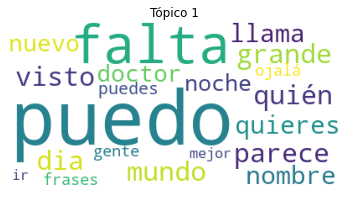

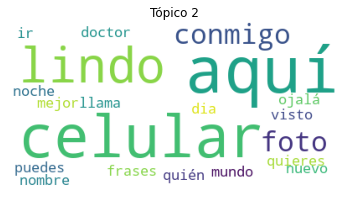

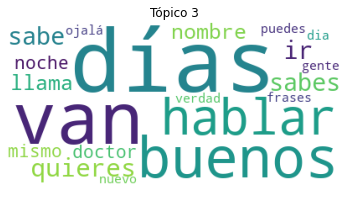

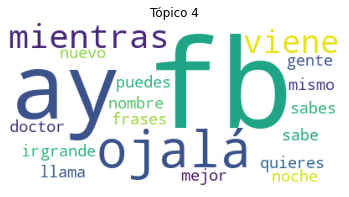

In [43]:
for i in range(1, 5):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

## Evaluacion del modelo

Para evaluar el rendimiento del modelo, estimaremos los tópicos en dos tweets diferentes. En el primer caso, escogeremos un tweet de entre los tweet utilizados en el corpus para entrenar el modelo y para la segunda prueba utilizaremos una nueva broma.

Así, empezamos escogiendo una tweet del corpus al azar y mostramos su contenido:

In [49]:
indice_tweet = random.randint(0,len(df))
tweet = df.iloc[indice_tweet]
print("Text: " + tweet.text)

Text: —durante años te esperé y ahora que te tengo tan cerca no lo puedo creer —¡gracias mi amor —¡cállate le estoy hablando al mundial


Primero debemos obtener la representación BOW del dataset y la distribución de los tópicos:

In [45]:
bow_tweet = corpus[indice_tweet]
distribucion_tweet = lda[bow_tweet]


Después, sacamos los índices y la contribución (proporción) de los tópicos más significativos para nuestros tweets y los mostramos en un gráfico de barras para un mejor entendimiento.

In [46]:
#Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in lda[bow_tweet]]
# Contribución de los topicos mas significativos
dist_contrib = [topico[1] for topico in lda[bow_tweet]]

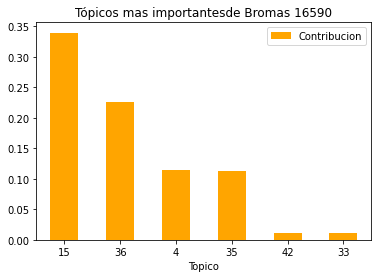

In [47]:
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })
distribucion_topicos.sort_values('Contribucion', 
                                 ascending=False, inplace=True)
ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico', 
                                   rot=0, color="orange",
                                   title = 'Tópicos mas importantes'
                                   'de Bromas ' + str(indice_tweet))

El tópico más predominante en los tweets es el 15, seguido de los tópicos 36 y 35. Seguidamente, imprimimos las palabras más significativas de estos.

In [48]:
for ind, topico in distribucion_topicos.iterrows():
    print("*** Tópico: " + str(int(topico.Topico)) + " ***")
    palabras = [palabra[0] for palabra in lda.show_topic(
        topicid=int(topico.Topico))]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

*** Tópico: 15 ***
cómo, dos, hola, cuál, iba, triste, quieres, nombre, mundo, llama 

*** Tópico: 36 ***
mujer, dicen, jajaja, cara, nuevo, ojalá, nombre, llama, doctor, mundo 

*** Tópico: 4 ***
fb, ay, ojalá, mientras, viene, noche, llama, doctor, quieres, nuevo 

*** Tópico: 35 ***
amo, nombre, nuevo, quieres, llama, doctor, mundo, frases, ojalá, visto 

*** Tópico: 42 ***
voy, hoy, papá, gracias, mundo, novio, frases, nuevo, gente, llama 

*** Tópico: 33 ***
si, nuevo, puedes, nombre, llama, doctor, mundo, noche, frases, gente 

